In [233]:
from refresh_functions import *
pd.options.display.float_format = '{:.4f}'.format
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from io import StringIO
pd.set_option('display.max_rows', 200)

#store my API key
with open('C:/Users/meich/.nasdaq/data_link_apikey.json') as f:
    data=json.load(f)
    key=data['api_key']
    avkey = data['alpha_vantage_key']
quandl.ApiConfig.api_key = key

In [17]:
#options data sub expires may 17. RTAT expires June 2

#STORE HISTORY FOR MODELLING--------------------------
# ops = pd.read_csv("C:/Users/meich/CareerDocs/projects/stock_prediction/Data/QUANTCHA_OPTIONS_ANALYTICS_4_17.csv",
#                   usecols=['ticker','date','pcrvolall','pcroiall'])

# rtat = pd.read_csv("C:/Users/meich/CareerDocs/projects/stock_prediction/Data/NDAQ_RTAT.csv")

## Options PC Ratios vs Price Returns (SPX)

### best predictors (time to buy - might be a local minima):
- activity_hi
- activity roc low
- volume roc low
- 

#### high vol PC = buy indicator (shorter term)
#### high oi PC = sell indicator (and vice versa - longer term)
#### high vol:OI PC Ratio = Buy indicator 

In [27]:
#DATA LOAD (SWITCH TO QUANDL lIVE WHEN AVAILABLE) -----------------------------------

# !! Alphavantage API only has unadjusted stock prices (so doesn't work for any that had splits...)
stock='SPY'
stockprices = AlphaVantagePrices(ticker=stock)

#rtat = quandl.get_table('NDAQ/RTAT', ticker=[stock],paginate=True)
rtat = pd.read_csv("C:/Users/meich/CareerDocs/projects/stock_prediction/Data/NDAQ_RTAT.csv")
rtat = rtat[rtat['ticker']==stock]

#ops = quandl.get_table('QUANTCHA/QOA', ticker=[stock],paginate=True)
ops = pd.read_csv("C:/Users/meich/CareerDocs/projects/stock_prediction/Data/QUANTCHA_OPTIONS_ANALYTICS_4_17.csv",
                  usecols=['ticker','date','pcrvolall','pcroiall'])
ops = ops[ops['ticker']==stock]

Data up to date
'AlphaVantagePrices' 0.00 mins


In [33]:
#DATA PROCESSING WORK -----------------------------------

#RTAT FROM NASDAQ
rtat['date'] = pd.to_datetime(rtat['date'])
rtat['activity'] = rtat['activity']*100

#OPTIONS FROM NASDAQ
ops = ops[['date','pcrvolall','pcroiall']]
ops['date'] = pd.to_datetime(ops['date'])
ops = ops.merge(stockprices,left_on='date',right_on='date')
ops = ops.merge(rtat[['date','activity','sentiment']],left_on='date',right_on='date')
ops['volume'] = (ops['volume'] - ops['volume'].min()) / (ops['volume'].max() - ops['volume'].min())

# #add variables and targets
ops['vol_oi_diff'] = ops['pcrvolall'] - ops['pcroiall']
ops['vol_oi_diff_over0'] = np.where(ops['vol_oi_diff']>0,1,0)
ops['activity_sentiment'] = ops['activity']*ops['sentiment']
ops['volume_sentiment'] = ops['volume']*ops['sentiment']
ops['vol_div_activity'] = ops['volume']/ops['activity']
ops['vol_x_activity'] = ops['volume']*ops['activity']

lag_predictor(ops,'Close',time=[3,5,10,15,20,30,50],date='date')
moving_avgs(ops,['pcroiall'],date='date',time=[5,10,15,20,25])
moving_avgs(ops,['pcrvolall'],date='date',time=[5,10,15,20,25])
moving_avgs(ops,['vol_oi_diff'],date='date',time=[5,10,15,20,25])
moving_avgs(ops,['activity'],date='date',time=[3,5,10,15,20,25])
moving_avgs(ops,['sentiment'],date='date',time=[5,10,15,20,25])
moving_avgs(ops,['activity_sentiment'],date='date',time=[5,10,15,20,25])
moving_avgs(ops,['volume_sentiment'],date='date',time=[5,10,15,20,25])
moving_avgs(ops,['volume'],date='date',time=[5,10,15,20,25])
pct_change_no_ticker(ops,['Close'],date='date',time=[3,5,10,15,20,30,50])

ops['Close_roc'] = ops['Close_pct5'] - ops['Close_pct20']
ops['pcroiall_roc'] = ops['pcroiall_MA5'] - ops['pcroiall_MA20']
ops['pcrvolall_roc'] = ops['pcrvolall_MA5'] - ops['pcrvolall_MA20']
ops['vol_oi_roc_diff'] = ops['pcrvolall_roc'] - ops['pcroiall_roc']
ops['activity_roc'] = ops['activity_MA5'] - ops['activity_MA20']
ops['activity_roc_mini'] = ops['activity_MA3'] - ops['activity_MA10']
ops['sentiment_roc'] = ops['sentiment_MA5'] - ops['sentiment_MA20']
ops['activity_sentiment_roc'] = ops['activity_sentiment_MA5'] - ops['activity_sentiment_MA20']
ops['volume_sentiment_roc'] = ops['volume_sentiment_MA5'] - ops['volume_sentiment_MA20']
ops['volume_roc'] = ops['volume_MA5'] - ops['volume_MA20']
quantile_inds(ops,cols=['pcroiall_roc','pcrvolall_roc','vol_oi_diff','activity_roc','sentiment_roc','activity_sentiment_roc','sentiment',
                       'activity','vol_oi_roc_diff','volume_sentiment_roc','volume_sentiment','vol_x_activity'],quantiles=[.05,.95])
#ops['activity_roc_diff'] = ops['activity_roc'].diff()
ops['activity_x_activity_roc'] = (ops['activity']*ops['activity_roc'])
ops['activity_roc_cross'] = np.sign(ops['activity_roc']).diff()

# #ops['cross'] = ops['pcroiall_roc']*ops['pcrvolall_roc']
# ops['pcrvolall_clipped'] = ops['pcrvolall'].clip(upper=2.5)

# ops['pcroiall_roc_inversion'] = ops['pcroiall_roc'].apply(lambda x: -1 if x > 0 else 0)
# ops['pcroiall_roc_inversion'] = ops['pcroiall_roc_inversion'].diff().fillna(0)  # Non-zero when crossover happens

# ops['pcrvolall_roc_inversion'] = ops['pcrvolall_roc'].apply(lambda x: -1 if x > 0 else 0)
# ops['pcrvolall_roc_inversion'] = ops['pcrvolall_roc_inversion'].diff().fillna(0)  # Non-zero when crossover happens

# ##NULL THE PANDEMIC ROWS
# mask = (ops['date'] >= '2020-02-01') & (ops['date'] <= '2020-12-31')
# ops.loc[mask, :] = np.nan

In [34]:
#if volume is highly correlated with activity (and if sentiment isn't useful - then I don't really need RTAT) 
#but volume is still only .57 corr with activity
#activity = ratio of USD traded in a ticker vs all tickers
#volume = actual volume of shares traded
# so they are very different measures

ops.corr(numeric_only=True)['Close_lag10'].sort_values()

Close_pct30                 -0.1084
Close_pct10                 -0.0906
Close_pct20                 -0.0799
Close_pct15                 -0.0758
Close_pct50                 -0.0733
Close_pct5                  -0.0712
Close_pct3                  -0.0545
activity_roc_hi             -0.0536
Close                       -0.0528
pcrvolall_roc_lo            -0.0498
activity_x_activity_roc     -0.0392
vol_oi_diff_lo              -0.0332
pcroiall_MA25               -0.0325
pcroiall_MA20               -0.0320
vol_x_activity_lo           -0.0314
activity_sentiment_roc      -0.0301
pcroiall_MA15               -0.0262
pcroiall_roc_lo             -0.0225
activity_roc                -0.0197
activity_lo                 -0.0195
pcroiall_MA10               -0.0183
sentiment_roc               -0.0144
sentiment_MA5               -0.0092
pcroiall_MA5                -0.0089
vol_oi_roc_diff_lo          -0.0087
volume_sentiment_roc        -0.0084
sentiment_MA10              -0.0074
sentiment_MA15              

In [110]:
#is it as simple as: buy when actroc and act are high? 

In [111]:
#check for inversion (and flag in data) of recent activity vs MA20 activity... seems relevent based on plotting act5/act20

In [104]:
conditional_avg(ops,'Close_lag30','activity_roc_hi==1 and activity_hi==1')

event mean: 1.8923149921939868
% of total events: 0.77
all rows mean: 1.5132643550453362


In [105]:
conditional_avg(ops,'Close_lag30','vol_x_activity_hi==1')

event mean: 4.465800620961142
% of total events: 4.95
all rows mean: 1.5132643550453362


In [106]:
conditional_avg(ops,'Close_lag30','activity_roc_cross==2')

event mean: 1.719932121089474
% of total events: 4.69
all rows mean: 1.5132643550453362


In [238]:
conditional_avg(ops,'Close_lag15','pcrvolall_roc_lo==1')

event mean: -3.5369639228842584
% of total events: 4.27
all rows mean: 0.41299379611570164


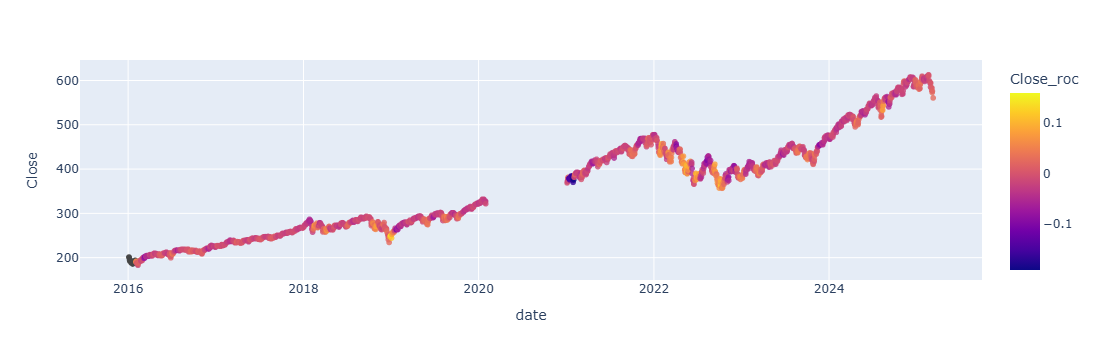

In [35]:
#ACTIVITY_HI is a GREAT predictor of the bottom (time to buy)
px.scatter(ops,x='date',y='Close',color='Close_roc',opacity=.8,
          hover_data=['Close_lag5','Close_lag15','Close_lag30','activity'])

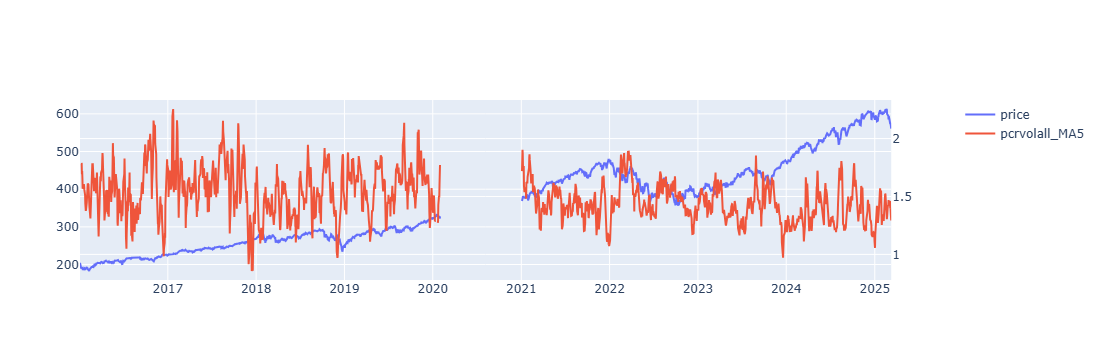

In [23]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=ops['date'], y=ops['Close'], name="price"),
    secondary_y=False,
)

# fig.add_trace(
#     go.Scatter(x=ops['date'], y=ops['pcroiall'], name="pcroiall"),
#     secondary_y=True,
# )
# fig.add_trace(
#     go.Scatter(x=ops['date'], y=ops['pcrvolall'], name="pcrvolall"),
#     secondary_y=True,
# )
fig.add_trace(
    go.Scatter(x=ops['date'], y=ops['pcrvolall_MA5'], name="pcrvolall_MA5"),
    secondary_y=True,
)

# # Add reference line at y=0 on secondary y-axis
# fig.add_hline(y=0, line_dash="dot", line_color="gray", 
#               annotation_text="lag50 price", annotation_position="bottom left", 
#               secondary_y=False)

fig.update_layout(height=600)
#fig.update_layout(width=1000)

fig.show()

In [25]:
features = ['pcroiall_roc','pcrvolall_roc','activity_roc','activity_MA5','sentiment_MA5','activity_MA25','activity_sentiment_roc_hi','vol_oi_roc_diff'
                        ,'activity_hi','sentiment_hi','Close_pct3','Close_pct5','Close_pct10','Close_pct15','Close_pct30'
            ,'activity_x_activity_roc','activity_roc_cross']
target = 'Close_lag10'

X = sm.add_constant(ops[features])
y = ops[target]

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Close_lag10   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     11.02
Date:                Sat, 24 May 2025   Prob (F-statistic):           1.05e-27
Time:                        08:50:51   Log-Likelihood:                 4532.1
No. Observations:                2024   AIC:                            -9030.
Df Residuals:                    2007   BIC:                            -8935.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [76]:
#durbin watsen? arima? (yes strong positive autocorrrelation because <2)
#### Explore ARIMA model NEXT

#eigenvalue? multicoll problems?
#train on last fold only?
#what to do if magnitude is wrong, but corr is high? can i just sccale the predicted values?

In [ ]:
# #TRY PCA, see if better performance (should help w variable multicollinearity
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from statsmodels.tsa.api import VAR

# # 2. Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(ops[features].dropna())

# # 3. Apply PCA
# pca = PCA(n_components=3)  # Reduce to 2 components
# pca_data = pca.fit_transform(scaled_data)

# # 4. Prepare PCA components as a DataFrame
# pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2','PC3'])

# pca.explained_variance_ratio_
# pca.components_
# ops = pd.concat([ops,pca_df],axis=1)

# X = sm.add_constant(ops[['PC1','PC2','PC3']])
# y = ops[target]

# model = sm.OLS(y, X, missing='drop').fit()
# #ops['Close_lag15_pred'] = model.predict(X)
# print(model.summary())

In [26]:
#lightgbm as an alternative for prediction... check with cross val scores. mighht get better scaled predictions.
features = ['pcroiall_roc','pcrvolall_roc','activity_roc','activity_MA5','sentiment_MA5','activity_MA25','activity_sentiment_roc_hi','vol_oi_roc_diff'
                        ,'activity_hi','sentiment_hi','Close_pct3','Close_pct5','Close_pct10','Close_pct15','Close_pct30'
            ,'activity_x_activity_roc','activity_roc_cross']
target = 'Close_lag10'
xgb_cross_val_mae(features, target, ops, cv=3,
                  xgb_params={"n_estimators": 1000,'max_depth':5})

# #lightgbm with ALL features (and GPU)
# features = [col for col in ops.columns if 'date' not in col.lower() and not col.startswith('Close_lag') and not col == 'Close']
# target = 'Close_lag15'
# lgb_cross_val_mae(features, target, ops, cv=3, lgb_params=None)

R2: -0.4689
Mean MAE: 0.0235
Mean Random MAE: 0.0242


In [109]:
features = ['pcroiall_roc','pcrvolall_roc','activity_roc','activity_MA5','sentiment_MA5','activity_MA25',
            'activity_sentiment_roc_hi','vol_oi_roc_diff','activity_hi','sentiment_hi','Close_pct3','Close_pct5',
            'Close_pct10','Close_pct15','Close_pct30','activity_x_activity_roc','activity_roc_cross']

#features = [col for col in ops.columns if 'date' not in col.lower() and not col.startswith('Close_lag') and not col == 'Close']
target = 'Close_lag10'

# Remove rows with NaNs
temp = ops.dropna(subset=[target] + features)
X = temp[features]
y = temp[target]

# Time-based 80/20 split
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train on 80%, test on 20%
model = XGBRegressor(reg_alpha=1, reg_lambda=1)
model.fit(X_train, y_train)

# # Predict on all data / add train test indicator
ops[f'{target}_pred'] = model.predict(ops[features])
ops['is_train'] = (np.arange(len(ops)) < train_size).astype(int)

r2_train_period = r2_score(y_train, temp[f'{target}_pred'][:train_size])
r2_test_period = r2_score(y_test, temp[f'{target}_pred'][train_size:])
mae_train = mean_absolute_error(y_train, temp[f'{target}_pred'][:train_size])
mae_test = mean_absolute_error(y_test, temp[f'{target}_pred'][train_size:])
sign_train = np.mean(np.sign(y_train) == np.sign(temp[f'{target}_pred'][:train_size]))
sign_test = np.mean(np.sign(y_test) == np.sign(temp[f'{target}_pred'][train_size:]))

print(f"R² on training period (first 80%): {r2_train_period:.4f}")
print(f"R² on testing period (last 20%):  {r2_test_period:.4f}")
print(f"MAE on training period:              {mae_train:.4f}")
print(f"MAE on testing period:              {mae_test:.4f}")
print(f"Sign agreement on training:          {sign_train:.2%}")
print(f"Sign agreement on testing:           {sign_test:.2%}")

R² on training period (first 80%): 0.3179
R² on testing period (last 20%):  0.0555
MAE on training period:              0.0163
MAE on testing period:              0.0197
Sign agreement on training:          75.51%
Sign agreement on testing:           63.55%


In [41]:
# scale_factor = ops[target].std()/ops[f'{target}_pred'].std()
# r2_train_period = r2_score(y_train, temp[f'{target}_pred'][:train_size])
# r2_test_period = r2_score(y_test, temp[f'{target}_pred'][train_size:]*scale_factor)
# mae_train = mean_absolute_error(y_train, temp[f'{target}_pred'][:train_size])
# mae_test = mean_absolute_error(y_test, temp[f'{target}_pred'][train_size:]*scale_factor)
# sign_train = np.mean(np.sign(y_train) == np.sign(temp[f'{target}_pred'][:train_size]))
# sign_test = np.mean(np.sign(y_test) == np.sign(temp[f'{target}_pred'][train_size:]*scale_factor))

# print(f"R² on training period (first 80%): {r2_train_period:.4f}")
# print(f"R² on testing period (last 20%):  {r2_test_period:.4f}")
# print(f"MAE on training period:              {mae_train:.4f}")
# print(f"MAE on testing period:              {mae_test:.4f}")
# print(f"Sign agreement on training:          {sign_train:.2%}")
# print(f"Sign agreement on testing:           {sign_test:.2%}")

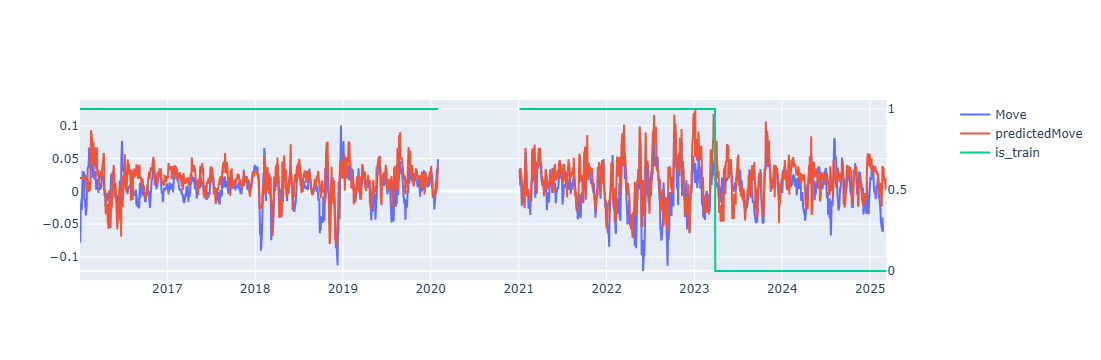

In [43]:
#XGBOOST WITH STD SCALING (and regularization)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=ops['date'], y=ops[target], name="Move"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=ops['date'], y=ops[f'{target}_pred']*scale_factor, name="predictedMove"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=ops['date'], y=ops['is_train'], name="is_train"),
    secondary_y=True,
)


fig.update_layout(height=600)

fig.show()

### Feature Importance Measures

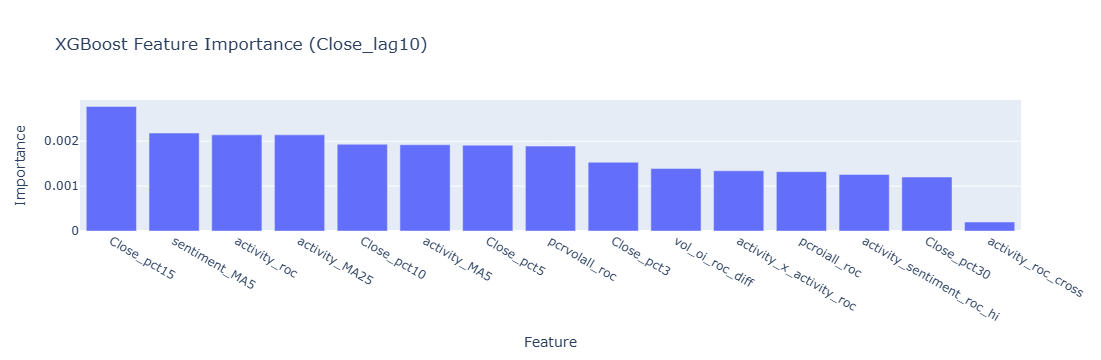

In [62]:
importance_dict = model.get_booster().get_score(importance_type='gain')
# ‘weight’: the number of times a feature is used to split the data across all trees.
# ‘gain’: the average gain across all splits the feature is used in.

importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})
importance_df['Importance'] = importance_df['Importance'].round(5)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
px.bar(importance_df, x='Feature', y='Importance', title=f'XGBoost Feature Importance ({target})', orientation='v')

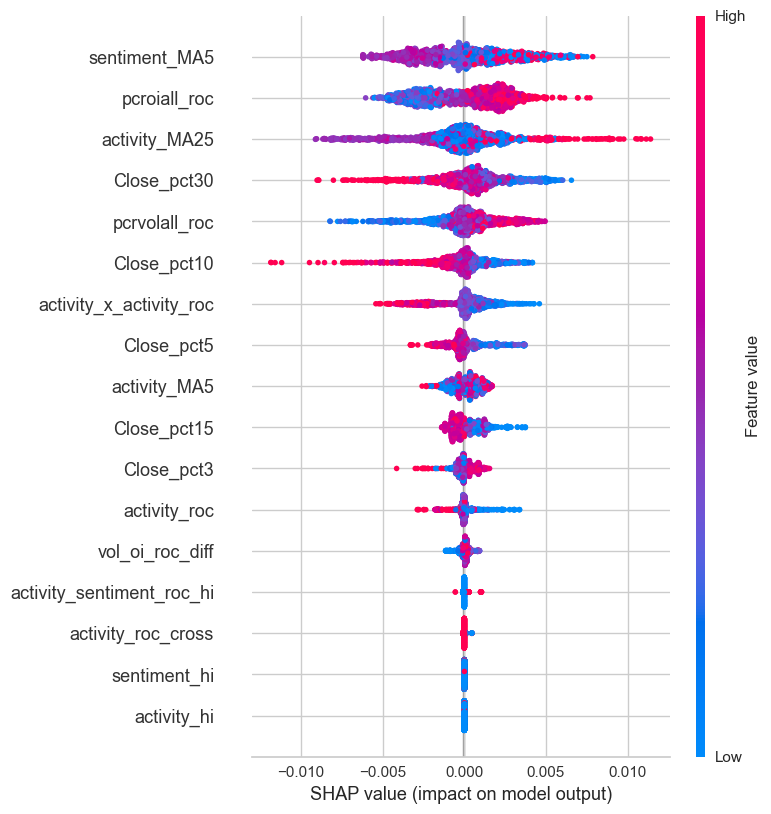

In [69]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

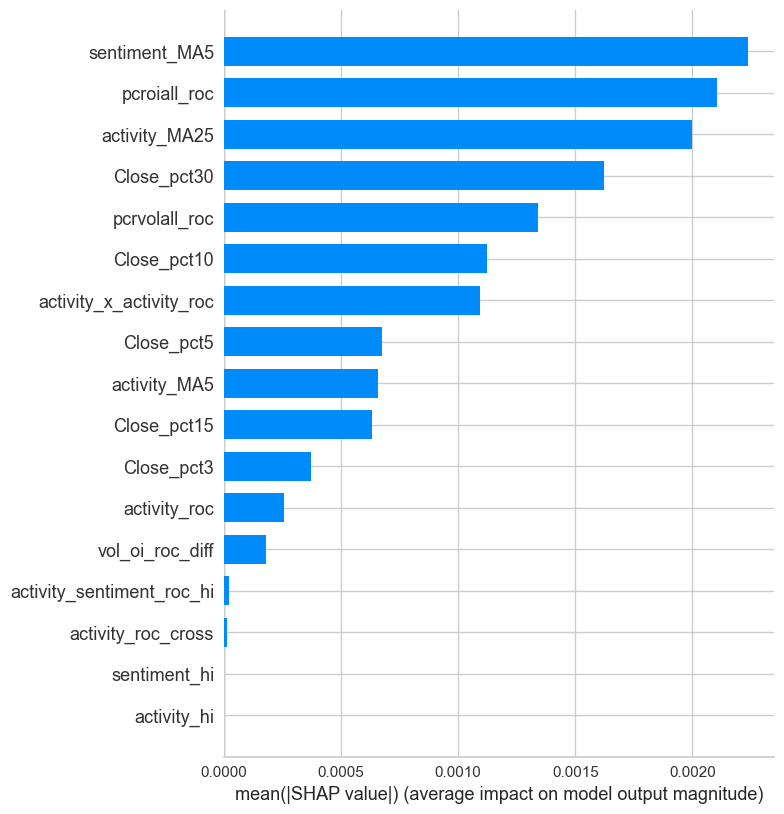

In [70]:
# Simple ABS highest shap scores plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

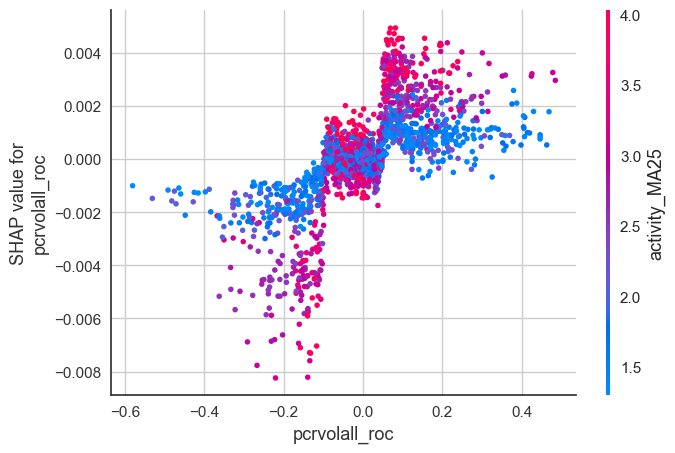

In [99]:
#Shap package automatically determines the most dependent based on covariance b/w feature and shap values
#can capture non-linear interactions.

shap.dependence_plot("pcrvolall_roc", shap_values.values, X_train)

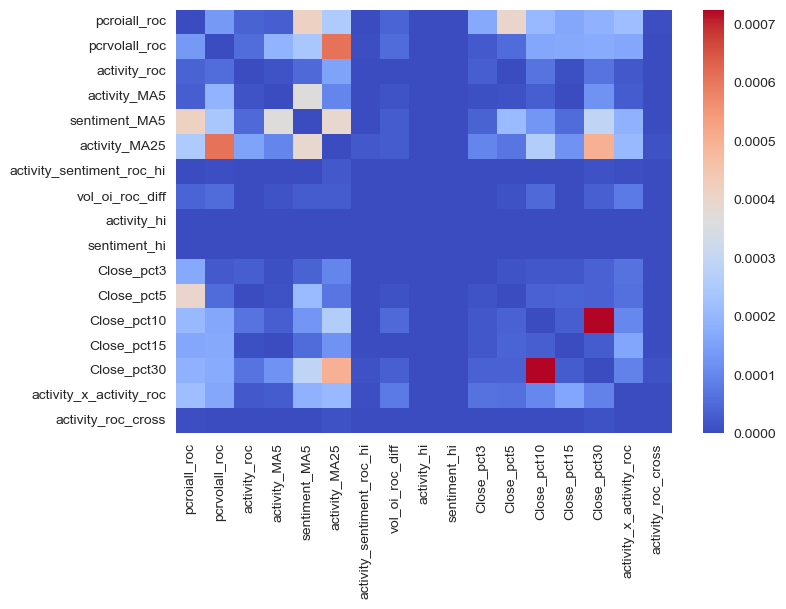

In [105]:
## Represent the average absolute magnitude of the interaction contribution from each feature pair independent of their main effects.

interaction_values = explainer.shap_interaction_values(X_train)
heatmap_data = np.abs(interaction_values).mean(axis=0)

# Remove diagonal (main effects)
np.fill_diagonal(heatmap_data, 0)
df_heatmap = pd.DataFrame(heatmap_data, index=features, columns=features)

sns.heatmap(df_heatmap, cmap="coolwarm")
plt.show()

In [ ]:
## Finding most important interaction cutoffs... PDP? Decision Trees? Something else?

In [ ]:
# tree-based extraction rules

In [106]:
# PDP plots

In [107]:
#Rulefit

In [108]:
#decision tree on shap values?

## VIX Analysis

In [240]:
#Get Latest VIX Price History File (Refreshed EOD by CBOE)
url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
response = requests.get(url)
csv_text = response.content.decode("utf-8")
vix = pd.read_csv(StringIO(csv_text))

vix = vix[['DATE','CLOSE']]
vix.columns = ['date','close']
vix['date'] = pd.to_datetime(vix['date'])

In [241]:
#Alternative to close lag -- better metric for options windows.
vix = future_max_gain_drop(vix,'close',windows=[5,10,15])

lag_predictor(vix,'close',time=[3,5,10,15,20,30,50],date='date')
moving_avgs(vix,['close'],date='date',time=[5,10,15,20,25,50,100])

## ema <-4 (similar to a 5_25 diff sma, doesn't hold on to past values as hard
vix['close_EMA50'] = vix['close'].ewm(span=50).mean()
vix['close_EMA5'] = vix['close'].ewm(span=5).mean()
vix['close_5_50_diff_ema'] = vix['close_EMA5'] - vix['close_EMA50']
vix['close_5_50_diff_ema_norm'] = vix['close_5_50_diff_ema']/vix['close_5_50_diff_ema'].rolling(5).std() #not entirely sure how this works

vix['close_5_20_diff'] = vix['close_MA5'] - vix['close_MA20']
vix['close_1_50_diff'] = vix['close'] - vix['close_MA50']
vix['close_1_5_diff'] = vix['close'] - vix['close_MA5']
vix['close_5_50_diff'] = vix['close_MA5']-vix['close_MA50']
vix['close_100_50_diff'] = vix['close_MA100']-vix['close_MA50']
vix['close_5_25_diff'] = vix['close_MA5']-vix['close_MA25']

#quantiles are inherently forward looking...
quantile_inds(vix,cols=['close_5_20_diff','close_5_50_diff','close_100_50_diff','close_5_50_diff','close_1_5_diff','close_5_50_diff_ema',
                       'close_5_50_diff_ema_norm'],quantiles=[.05,.95])

#buy indicator vars
vix['close_5_50_diff_neg6'] = np.where(vix['close_5_50_diff']<=-6,1,0)
vix['close_5_50_diff_neg4'] = np.where(vix['close_5_50_diff']<=-4,1,0)
vix['close_5_50_diff_neg8'] = np.where(vix['close_5_50_diff']<=-8,1,0)
vix['close_5_50_diff_ema_neg4'] = np.where(vix['close_5_50_diff_ema']<=-4,1,0)
vix['close_5_50_diff_ema_norm_neg30'] = np.where(vix['close_5_50_diff_ema_norm']<=-30,1,0)
vix['close_5_50_diff_ema_norm_neg20'] = np.where(vix['close_5_50_diff_ema_norm']<=-20,1,0)
vix['close_5_50_diff_ema_norm_neg10'] = np.where(vix['close_5_50_diff_ema_norm']<=-10,1,0)

#trigger + under mean vix (could use 75th percentile vix at 23 as well)
vix['buy_ind6'] = np.where((vix['close_5_50_diff_neg6'])  & (vix['close']<20),1,0)
vix['buy_ind4'] = np.where((vix['close_5_50_diff_neg4'])  & (vix['close']<20),1,0)
vix['buy_ind_ema10'] = np.where((vix['close_5_50_diff_ema_norm_neg10'])  & (vix['close']<20),1,0)
vix['buy_ind_ema20'] = np.where((vix['close_5_50_diff_ema_norm_neg20'])  & (vix['close']<20),1,0)

# ##NULL THE PANDEMIC ROWS
# mask = (vix['date'] >= '2020-02-01') & (vix['date'] <= '2020-12-31')
# vix.loc[mask, :] = np.nan

In [221]:
#buy indicator vars
vix['close_5_50_diff_neg6'] = np.where(vix['close_5_50_diff']<=-6,1,0)
vix['close_5_50_diff_neg4'] = np.where(vix['close_5_50_diff']<=-4,1,0)
vix['close_5_50_diff_neg8'] = np.where(vix['close_5_50_diff']<=-8,1,0)
vix['close_5_50_diff_ema_neg4'] = np.where(vix['close_5_50_diff_ema']<=-4,1,0)
vix['close_5_50_diff_ema_norm_neg30'] = np.where(vix['close_5_50_diff_ema_norm']<=-30,1,0)
vix['close_5_50_diff_ema_norm_neg20'] = np.where(vix['close_5_50_diff_ema_norm']<=-20,1,0)
vix['close_5_50_diff_ema_norm_neg10'] = np.where(vix['close_5_50_diff_ema_norm']<=-10,1,0)

#trigger + under mean vix (could use 75th percentile vix at 23 as well)
vix['buy_ind6'] = np.where((vix['close_5_50_diff_neg6'])  & (vix['close']<20),1,0)
vix['buy_ind4'] = np.where((vix['close_5_50_diff_neg4'])  & (vix['close']<20),1,0)
vix['buy_ind_ema10'] = np.where((vix['close_5_50_diff_ema_norm_neg10'])  & (vix['close']<20),1,0)
vix['buy_ind_ema20'] = np.where((vix['close_5_50_diff_ema_norm_neg20'])  & (vix['close']<20),1,0)

In [198]:
# # Calculate difference between them
# vix['cross_diff'] = vix['close_1_5_diff'] - vix['close_5_50_diff']

# # Identify crossover points where long_diff crosses above short_diff
# vix['inflection_up'] = np.where((vix['cross_diff'].shift(1) < 0) & (vix['cross_diff'] >= 0),1,0)

# # Optional: inflection where long_diff crosses *below*
# vix['inflection_down'] = np.where((vix['cross_diff'].shift(1) > 0) & (vix['cross_diff'] <= 0),1,0)

In [200]:
vix.corr(numeric_only=True)['max_5_gain'].sort_values()

close                            -0.0716
close_EMA50                      -0.0714
close_MA25                       -0.0703
close_MA50                       -0.0702
close_MA100                      -0.0690
close_MA20                       -0.0683
close_EMA5                       -0.0662
close_MA15                       -0.0662
close_MA5                        -0.0639
close_MA10                       -0.0633
close_1_5_diff                   -0.0414
close_5_50_diff_ema_norm         -0.0288
close_100_50_diff_lo             -0.0288
close_1_5_diff_hi                -0.0232
close_100_50_diff_hi             -0.0223
close_5_50_diff_neg4             -0.0190
close_1_50_diff                  -0.0135
close_5_50_diff_lo               -0.0082
close_5_50_diff_ema              -0.0053
close_5_20_diff_lo               -0.0034
close_5_50_diff_ema_neg4         -0.0028
close_1_5_diff_lo                -0.0021
close_5_50_diff_hi                0.0020
close_5_50_diff                   0.0023
close_5_50_diff_

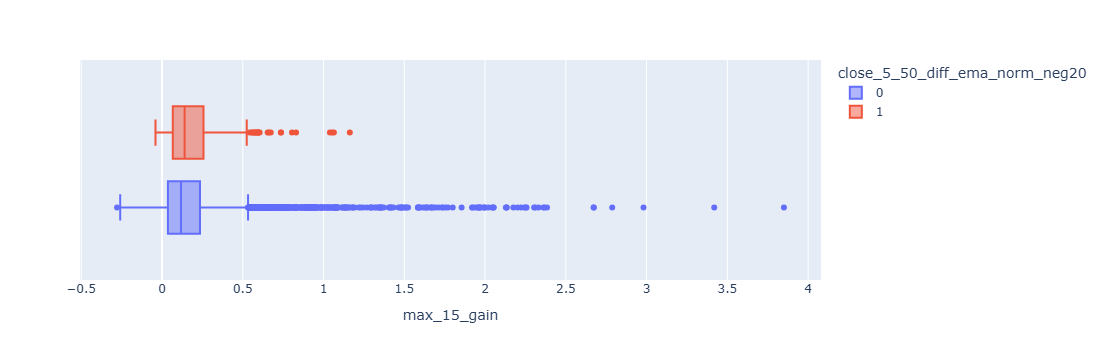

In [214]:
px.box(vix,x='max_15_gain',color='close_5_50_diff_ema_norm_neg20')

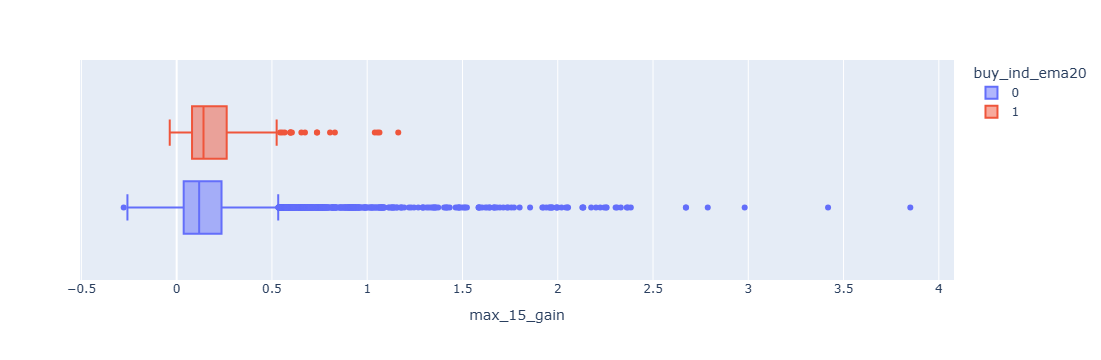

In [222]:
px.box(vix,x='max_15_gain',color='buy_ind_ema20')

In [228]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [122]:
#difference in median for gain vs difference in median for drop.

In [227]:
conditional_avg(vix,'max_5_gain','buy_ind_ema10==1',np.nanmedian)

event nanmedian: 6.59%
% of total events: 10.02%
all rows nanmedian: 4.91%


In [226]:
conditional_avg(vix,'max_15_gain','buy_ind_ema10==1',np.nanmedian)

event nanmedian: 15.59%
% of total events: 9.96%
all rows nanmedian: 11.88%


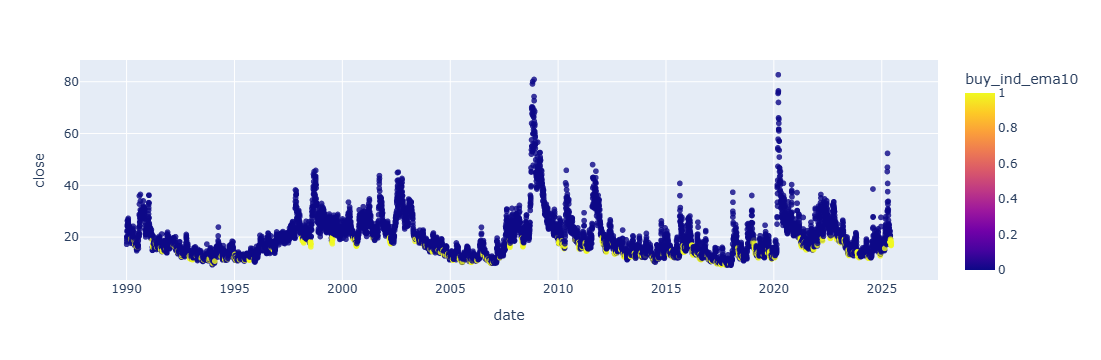

In [225]:
px.scatter(vix,x='date',y='close',color='buy_ind_ema10',opacity=.8)

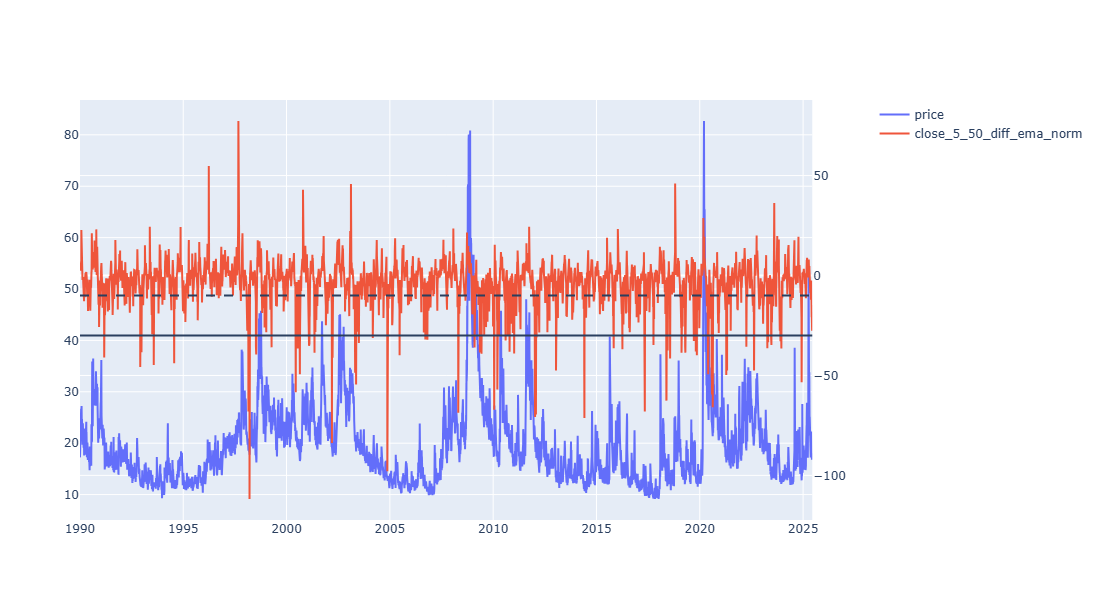

In [217]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=vix['date'], y=vix['close'], name="price"),
    secondary_y=False,
)

# fig.add_trace(
#     go.Scatter(x=vix['date'], y=vix['close_5_50_diff_ema'], name="close_5_50_diff_ema"),
#     secondary_y=True,
# )
fig.add_trace(
    go.Scatter(x=vix['date'], y=vix['close_5_50_diff_ema_norm'], name="close_5_50_diff_ema_norm"),
    secondary_y=True,
)

fig.update_layout(height=600)
fig.add_hline(-30,secondary_y=True)
fig.add_hline(-10,secondary_y=True,line_dash='dash')

fig.show()

In [155]:
vix['close_EMA50'] = vix['close'].ewm(span=50).mean()
vix['close_EMA5'] = vix['close'].ewm(span=5).mean()
vix['close_5_50_diff_ema'] = vix['close_EMA5'] - vix['close_EMA50']

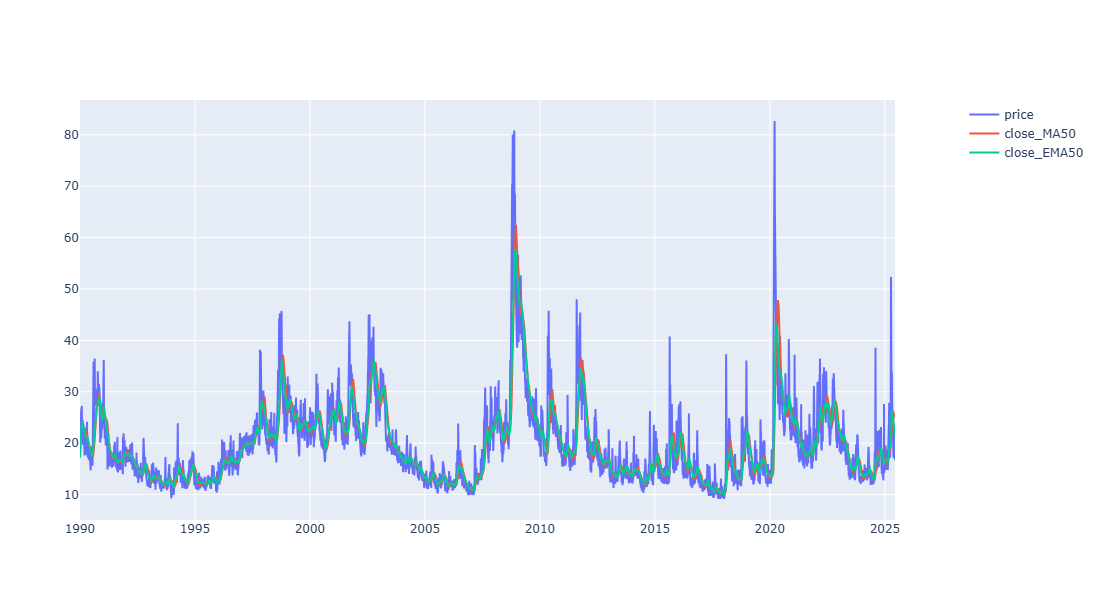

In [153]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=vix['date'], y=vix['close'], name="price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=vix['date'], y=vix['close_MA50'], name="close_MA50"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=vix['date'], y=vix['close_EMA50'], name="close_EMA50"),
    secondary_y=False,
)

fig.update_layout(height=600)
fig.add_hline(0,secondary_y=True)

fig.show()

In [194]:
features = ['close','close_5_50_diff_ema_norm_neg30']
target = 'max_15_gain'

X = sm.add_constant(vix[features])
y = vix[target]

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            max_15_gain   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     78.14
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           2.28e-34
Time:                        20:19:16   Log-Likelihood:                -350.70
No. Observations:                8931   AIC:                             707.4
Df Residuals:                    8928   BIC:                             728.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [19]:
features = ['close','close_50_5_diff']
target = 'max_15_gain'

# Remove rows with NaNs
temp = vix.dropna(subset=[target] + features)
X = temp[features]
y = temp[target]

# Time-based 80/20 split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train on 80%, test on 20%
model = XGBRegressor(reg_alpha=1, reg_lambda=1)
model.fit(X_train, y_train)

# # Predict on all data / add train test indicator
vix[f'{target}_pred'] = model.predict(vix[features])
vix['is_train'] = (np.arange(len(vix)) < train_size).astype(int)

r2_train_period = r2_score(y_train, temp[f'{target}_pred'][:train_size])
r2_test_period = r2_score(y_test, temp[f'{target}_pred'][train_size:])
mae_train = mean_absolute_error(y_train, temp[f'{target}_pred'][:train_size])
mae_test = mean_absolute_error(y_test, temp[f'{target}_pred'][train_size:])
sign_train = np.mean(np.sign(y_train) == np.sign(temp[f'{target}_pred'][:train_size]))
sign_test = np.mean(np.sign(y_test) == np.sign(temp[f'{target}_pred'][train_size:]))

print(f"R² on training period (first 80%): {r2_train_period:.4f}")
print(f"R² on testing period (last 20%):  {r2_test_period:.4f}")
print(f"MAE on training period:              {mae_train:.4f}")
print(f"MAE on testing period:              {mae_test:.4f}")
print(f"Sign agreement on training:          {sign_train:.2%}")
print(f"Sign agreement on testing:           {sign_test:.2%}")

R² on training period (first 80%): 0.3863
R² on testing period (last 20%):  -0.0797
MAE on training period:              0.1157
MAE on testing period:              0.2138
Sign agreement on training:          86.36%
Sign agreement on testing:           84.47%


## HEAVY TRUCK SALES (FRED) vs Price Returns (MONTHLY)

In [ ]:
# investigate the idea that heavy truck sales can be used as a leading indicator of market downturns.

In [ ]:
ht = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/heavytrucksales_units_monthly.csv')
ht['observation_date'] = pd.to_datetime(ht['observation_date'])

In [ ]:
#pct_change_no_ticker(ht,['ht_units_month'],date='observation_date')

In [ ]:
lag_predictor(ht,'NASDAQCOM',date='observation_date')
moving_avgs(ht,['ht_units_month'],date='observation_date')

#calculate acceleration of unit movement (short MA - Long MA)
ht['changerate'] = ht['ht_units_month_MA2'] - ht['ht_units_month_MA5']

In [ ]:
quantile_inds(ht,['changerate'],quantiles=[.05,.95])

In [ ]:
#NULL THE PANDEMIC ROWS
mask = (ht['observation_date'] >= '2020-01-01') & (ht['observation_date'] <= '2020-08-31')
ht.loc[mask, :] = np.nan

In [ ]:
ht.corr(numeric_only=True)['NASDAQCOM_lag3']

In [ ]:
conditional_avg(ht, 'NASDAQCOM_lag3', 'changerate <-.035')

In [ ]:
conditional_avg(ht, 'NASDAQCOM_lag3', 'changerate_hi ==1')

In [ ]:
ht['%Change'] = ht.apply(lambda row: f"{row['NASDAQCOM_lag3']:.2f}" if row['changerate'] < -0.02 else "", axis=1)

In [ ]:
px.scatter(ht,x='observation_date',y='NASDAQCOM',color='changerate_lo',hover_data=['NASDAQCOM_lag1'])

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=ht['observation_date'], y=ht['NASDAQCOM_lag3'], name="nasdaq3"),
    secondary_y=False,
)

# fig.add_trace(
#     go.Scatter(x=ht['observation_date'], y=ht['ht_units_month_MA3'], name="ht_units_month_MA3"),
#     secondary_y=True,
# )

fig.add_trace(
    go.Scatter(x=ht['observation_date'], y=ht['changerate'], name="changerate"),
    secondary_y=True,
)

fig.show()

In [ ]:
# e.g. 1-month returns for X and Y
test= ht.dropna()
r, p = pearsonr(test['changerate'], test['NASDAQCOM_lag3'])
print(f"Correlation: {r:.4f}, p-value: {p:.4g}")

# X = sm.add_constant(ht[['changerate','ht_units_month_MA2','ht_units_month_MA5','ht_units_month_MA10']])
# y = ht['NASDAQCOM_lag3']

# model = sm.OLS(y, X, missing='drop').fit()
# print(model.summary())

## CONSUMER SENTIMENT (UMICH) VS NASDAQ (WEEKLY)